# Introduction:
Today, we'll be walking through a data analysis process using a medical dataset. Our goal is to prepare the data, visualize it, and build a Naive Bayes classifier to predict patient readmission. We'll be using Python and several libraries that are standard in the field of data science.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from scipy.stats import boxcox
from summarytools import dfSummary

# Data Loading and Initial Exploration:
First, we load our dataset using pandas. Let’s take a quick look at the first few entries with the .head() method to understand what we're working with.

In [2]:
medical_data = pd.read_csv('medical_clean.csv')
medical_data.head()

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Eva,AL,Morgan,35621,34.34960,-86.72508,...,3726.702860,17939.403420,3,3,2,2,4,3,3,4
1,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,Marianna,FL,Jackson,32446,30.84513,-85.22907,...,4193.190458,17612.998120,3,4,3,4,4,4,3,3
2,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,Sioux Falls,SD,Minnehaha,57110,43.54321,-96.63772,...,2434.234222,17505.192460,2,4,4,4,3,4,3,3
3,4,A879973,1dec528d-eb34-4079-adce-0d7a40e82205,cd17d7b6d152cb6f23957346d11c3f07,New Richland,MN,Waseca,56072,43.89744,-93.51479,...,2127.830423,12993.437350,3,5,5,3,4,5,5,5
4,5,C544523,5885f56b-d6da-43a3-8760-83583af94266,d2f0425877b10ed6bb381f3e2579424a,West Point,VA,King William,23181,37.59894,-76.88958,...,2113.073274,3716.525786,2,1,3,3,5,3,4,3


# Data Cleaning
Real-world data is rarely clean. We have to drop irrelevant columns, like survey items and demographic information that won't be useful for our prediction model. Notice that we also convert the 'Age' column to float to ensure numerical consistency.

In [3]:
# Dropping survey columns Item1 to Item8
medical_data.drop(['Item1','Item2','Item3','Item4','Item5','Item6','Item7','Item8'],axis=1,inplace=True)
# Dropping demographic columns 
medical_data.drop(columns = ['CaseOrder','Customer_id','Interaction','UID','City','State','County','Zip','Lat','Lng','Area','TimeZone','Job','Marital','Children','Gender','Population'],inplace = True)
# Converting "Age" column to float
medical_data['Age'] = medical_data['Age'].astype('float64')

In [4]:
print(medical_data.select_dtypes(include='object').columns +' (Categorical)')

print(medical_data.select_dtypes(exclude='object').columns +' (Numerical)')

Index(['ReAdmis (Categorical)', 'Soft_drink (Categorical)',
       'Initial_admin (Categorical)', 'HighBlood (Categorical)',
       'Stroke (Categorical)', 'Complication_risk (Categorical)',
       'Overweight (Categorical)', 'Arthritis (Categorical)',
       'Diabetes (Categorical)', 'Hyperlipidemia (Categorical)',
       'BackPain (Categorical)', 'Anxiety (Categorical)',
       'Allergic_rhinitis (Categorical)', 'Reflux_esophagitis (Categorical)',
       'Asthma (Categorical)', 'Services (Categorical)'],
      dtype='object')
Index(['Age (Numerical)', 'Income (Numerical)', 'VitD_levels (Numerical)',
       'Doc_visits (Numerical)', 'Full_meals_eaten (Numerical)',
       'vitD_supp (Numerical)', 'Initial_days (Numerical)',
       'TotalCharge (Numerical)', 'Additional_charges (Numerical)'],
      dtype='object')


# Correlation Matrix Visualization:
We then compute and visualize the correlation matrix. This heatmap gives us a high-level view of how different variables relate to each other, with colors indicating the strength and direction of the correlation.


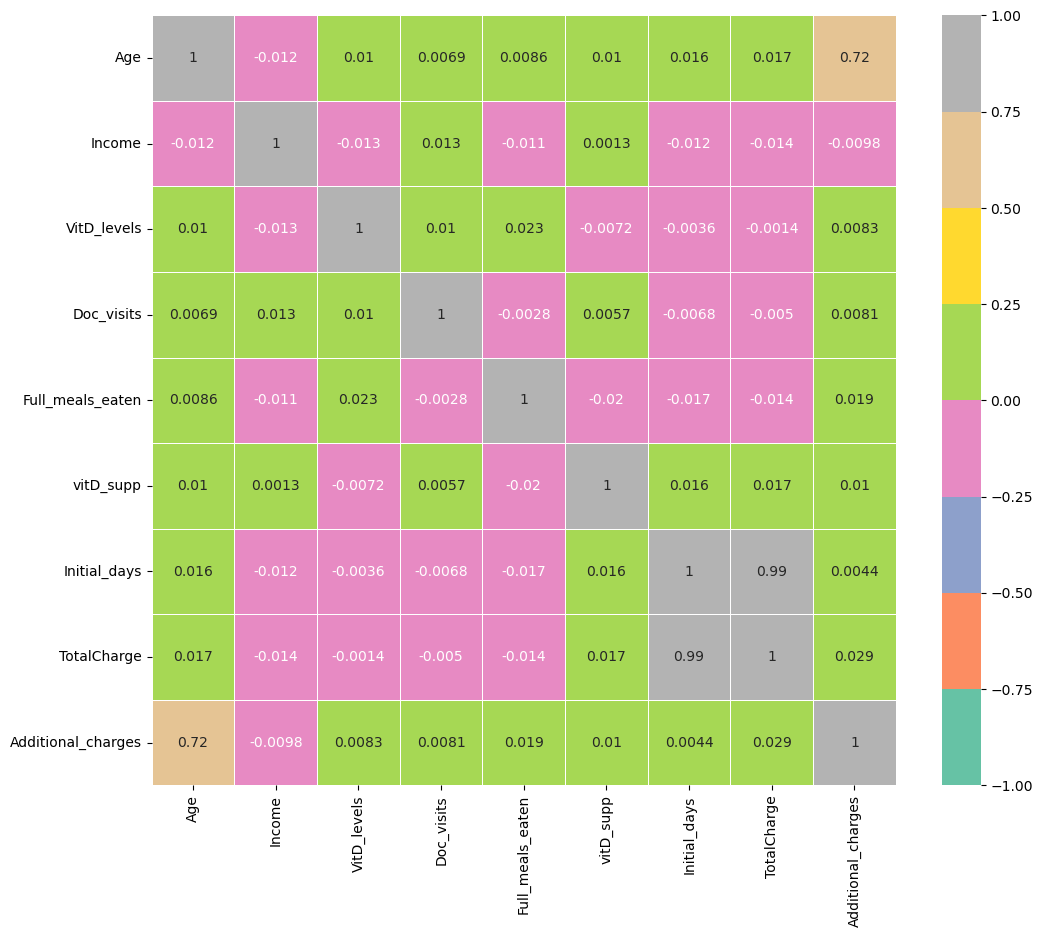

In [5]:
# Compute correlation matrix
corr_matrix = medical_data.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True,vmin=-1, vmax=1,linewidths=.5, cmap="Set2")
plt.show()

# Further Data Cleaning:
We proceed by dropping additional columns with high correlations or that aren't needed for our model, like 'Additional_charges' and 'Initial_days'.


In [6]:
medical_data.drop(columns=['Additional_charges','Initial_days'],inplace=True)

In [7]:
dfSummary(medical_data,is_collapsible = True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Age[float64],Mean (sd) : 53.5 (20.6)min < med < max:18.0 < 53.0 < 89.0IQR (CV) : 35.0 (2.6),72 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACrUlEQVR4nO3asU/bQBiG8e8Sgi6E2gpJYcvSEalDJBaWbh37x3bt1iFInRm6dGJBSMgkiksUY6dDkaoONPY5Jn2t57eGL3Z0z+ELwm02GwP+d5193wBQxsG+bwDt4Zzrm9lh4Ph6s9k8vvQioWInnHP90Wj0KYqiYcj8YrFInHOfX4p1a6hN7hK0ymEURcPLy8vHOI5XVQbn87mfzWbD+/v7QzOrHmrTuwTtE8fx6vT09GfAaP9fL277jdroLgHKKnVGbWqXYPfaelRr7Zepmgtm9vtPd0Xg7F4WvM1HtUZDzfO8Z2aRcy70LUJj8ScnJx/jOB6EXDTP816apu+Oj49/dDqdrOr8w8PD0jn3xcwqHZee1Ym8tUe1xkJN07SXZdn7yWTS7Xa7lResTixZlnkzO7+4uPg2Ho8XVa99c3MzvL6+fjudTr+fnZ0lVWZvb2/fXF1dfZhMJuOQz10z8qgoil4cx0nbjmqNhbperw+890fT6XRVdbHN6sXyPHvkvc9CFixJkr6Z2WAwqHw2T5KkH/q560aeZZnP8/x8tVp9NbPKn7vmEzAqiqIXMlhG42fUkMU2qx9L1evt2mtHbvZngz49PXWrztZ9AtbdJNu09suUsrqbO8SOnoBBm6QMQsVf9rFJyuC/pyCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCHhoMwPzedzX/WNl8ulNzNL09Tf3d0dvea86rVV77vufJm+fgFFPnL1B2RO9gAAAABJRU5ErkJggg=="">",0(0.0%)
2,Income[float64],Mean (sd) : 40490.5 (28521.2)min < med < max:154.1 < 33768.4 < 207249.1IQR (CV) : 34697.6 (1.4),"9,993 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACkElEQVR4nO3cMW/aQBiA4e9KQAYiAyKCjZWhUgdGlv6D/tiu3YrEjsQ/YEMyGIQbB2PcKVPTJNzZ6X3u++xnbnhldHB3pigKAXz36V9PAHiPuyofboxpi0jL4RHnoigey5oP9KosVGNMezgcfgvDcGD7jOPxuDfGfCdWVPlGbYVhOJjP54+9Xi+9dfDhcAiWy+UgiqKWiBDqf67Sr34RkV6vl45Go1+Ww9ulTgZqsZiCCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQpv/jPlsLEkvF6vTYtxwB9eDdVlY0mWZUGe55/TNP0pIrZ/oQIi8vYb1XpjyWazGazX687lcmk4zA8QkXduSrHZWLLf79lQgtKwmIIKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFSo/1+8iz/OmiITGGJvhXAdUI96GmiRJM8uyL5PJpNFoNG6+aYXrgOrF21DP5/NdEASd2WyWjsfj/S1juQ6ofrwN9Vm327W9EojdWzXCYgoqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQre70e15XiMRYSjLF6pZaiux1hEOMrim1qG6nKMRYSjLD6qZajPHI6xiHCUxSsspqACoUIFQoUKhAoVCBUqECpUIFSoQKhQodY/+Lvgyku/EOoLuPLSP4T6Aq689A+hvoIrL/3BYgoq8EatAAux8hFqyViIVYNQS+a6EFssFqMoih6MMUfbKdQxckKtiM1CrIwjNHEcn4wxP0TEZry3kb8r1MPhENz64NPpFIiIJEkSbLfbzkeO1/rZu93uPgiCznQ6Nf1+/+mWsSIicRzfr1arr5PJ5MEmdMfIXT0VRfHXz/0NFyk98m/OwwoAAAAASUVORK5CYII="">",0(0.0%)
3,ReAdmis[object],1. No2. Yes,"6,331 (63.3%)3,669 (36.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOElEQVR4nO3bwYnDMBRF0a/BhMlGwhhcjIuYYqcIdWOMtUhCNsoiNfjJ1r+ngp9wMST4hVqrAQrBzO5mdmt9COxda322PuJIwzRNfzHGsfUh3pVSthDCf8/BDTHGcVmWZ0rp1foYr/Z9/805j+u63sys39jMzFJKr3meH62Pce7e+oCj/bQ+AH4QG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggM5h9X95rfYhnXr7/oZSy5ZxHc/Dy3pmVUjYze7e+40gMXs6j+8FLYMoHFS9Ptu6fGlfgYsrnYSZ3Bd1P+bzM5K7Ay5SPX9onwJ+6kCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGm+ylfz5/talxM+TzM5K6AwQtkPgpbat+zkoHLAAAAAElFTkSuQmCC"">",0(0.0%)
4,VitD_levels[float64],Mean (sd) : 18.0 (2.0)min < med < max:9.8 < 18.0 < 26.4IQR (CV) : 2.7 (8.9),"9,976 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACkElEQVR4nO3csY7aQBCA4dn4IAYSW4AEHS9wUgpK+rR52LTpUlBczRvQIAQyIHznYIzTpYLk8Jqws/xfP6ctfp1s3+2YsiwFcN2Hex8AeI+nex/AVcaYlog0K44fyrJ8q/M8j45QzzDGtPr9/rcoirpV5ne7XWKM+U6s9SHU85pRFHUnk8lbHMfZNYPb7TacTqfd9XrdFBFCrQmh/kUcx9lgMHitMNqq/TAPjpcpqECoUIFQoQLPqDdQFEVDRCJjTJVxPm2dQag1S9O0kef5l9FoFARBcNUXAxE+bV1CqDU7HA5PYRi2x+NxNhwOk2tm+bR1GaHeSKfT4dNWjXiZggqEChUIFSoQKl

# Data Encoding:
Machine Learning models require numerical input, so we encode binary columns to 0s and 1s using a function that applies LabelEncoder. For categorical variables with more than two categories, we'll later use one-hot encoding.

In [8]:
def encode_binary(data, binary_columns=None):
    """
    Encodes binary columns into 0s and 1s using LabelEncoder.

    Parameters:
    - data: DataFrame to be encoded
    - binary_columns: List of binary columns to be encoded into 0s and 1s. If None, it will be inferred from the data.

    Returns:
    - DataFrame with binary encoded columns
    """
    
    # If 'binary_columns' is not provided, infer it from the data.
    if binary_columns is None:
        binary_columns = data.nunique()[data.nunique() == 2].keys().tolist()

    le = LabelEncoder()

    for col in binary_columns:
        data[col] = le.fit_transform(data[col])
        data[col] = data[col].astype('int64')

    return data

In [9]:
medical_data_encoded= medical_data.copy()
medical_data_encoded = encode_binary(medical_data_encoded)
medical_data_encoded.head().T

,0,1,2,3,4
Age,53.0,51.0,53.0,78.0,22.0
Income,86575.93,46805.99,14370.14,39741.49,1209.56
ReAdmis,0,0,0,0,0
VitD_levels,19.141466,18.940352,18.057507,16.576858,17.439069
Doc_visits,6,4,4,4,5
Full_meals_eaten,0,2,1,1,0
vitD_supp,0,1,0,0,2
Soft_drink,0,0,0,0,1
Initial_admin,Emergency Admission,Emergency Admission,Elective Admission,Elective Admission,Elective Admission
HighBlood,1,1,1,0,0


In [10]:
def encode_one_hot(data, columns_to_encode):
    """
    Encodes specified columns using one-hot encoding.

    Parameters:
    - data: DataFrame to be encoded
    - columns_to_encode: List of columns to be one-hot encoded

    Returns:
    - DataFrame with one-hot encoded columns
    """
    
    # Initialize a OneHotEncoder with specific settings:
    # 'drop="first"' means drop the first category in each feature to avoid multicollinearity.
    # 'sparse_output=False' means the output should be a dense array (not a sparse matrix).
    encoder = OneHotEncoder(drop='first', sparse_output=False)

    # Apply the encoder to transform the specified columns into one-hot encoded format.
    encoded_data = encoder.fit_transform(data[columns_to_encode])

    # Convert the encoded data into a DataFrame with appropriate column names.
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

    # Concatenate the original data (excluding the columns_to_encode) with the encoded data.
    # The final result replaces the original categorical columns with their one-hot encoded counterparts.
    data = pd.concat([data.drop(columns_to_encode, axis=1), encoded_df], axis=1)

    return data

In [11]:
columns_to_encode = medical_data_encoded.select_dtypes(include=['object']).columns
medical_data_encoded = encode_one_hot(medical_data_encoded, columns_to_encode)

# Outlier Detection:
Outliers can skew our analysis, so we identify them using the IQR method. We print the number of outliers in columns that are of interest to us, like 'Age' and 'Income'.

In [12]:
def detect_outliers(data, columns_of_interest):
    """
        Detects outliers in the specified columns using IQR methods.

        Parameters:
        - data: DataFrame to detect outliers from
        - columns_of_interest: List of columns to check for outliers

        Returns:
        - IQR outliers count for each column
        """
    Q1 = data[columns_of_interest].quantile(0.25)
    Q3 = data[columns_of_interest].quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers_count = ((data[columns_of_interest] < (Q1 - 1.5 * IQR)) | 
                          (data[columns_of_interest] > (Q3 + 1.5 * IQR))).sum()
    
    return iqr_outliers_count

In [13]:
columns_of_interest = ['Age', 'Income', 'VitD_levels','TotalCharge']
iqr_outliers = detect_outliers(medical_data, columns_of_interest)

print('\nIQR Outliers')
display(iqr_outliers)


IQR Outliers


Age              0
Income         326
VitD_levels     60
TotalCharge      0
dtype: int64

# Data Transformation:
Some algorithms perform better when data follows a normal distribution. Here, we transform the 'Income' column using log and Box-Cox transformations and visualize the results.

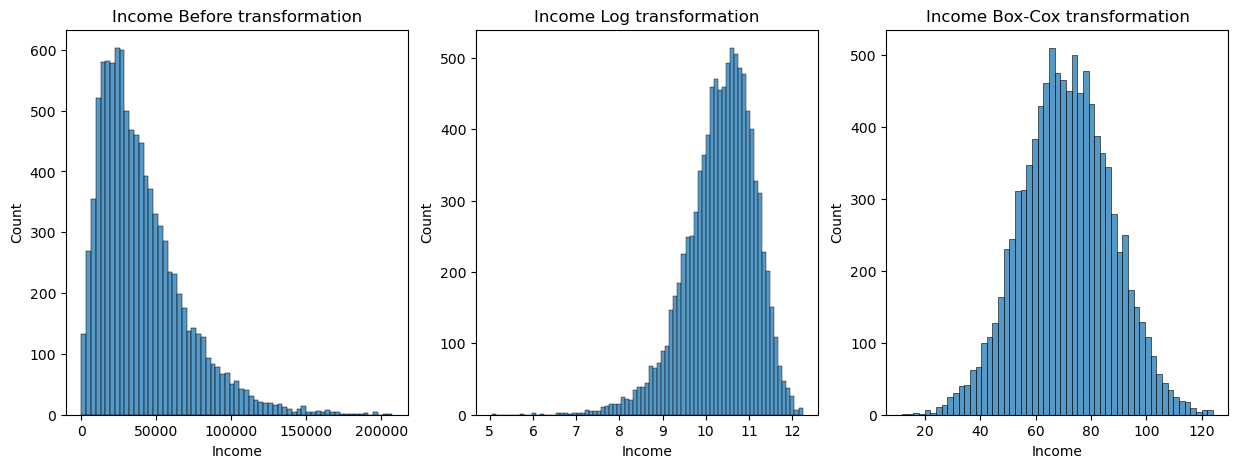

In [14]:
axes,fig = plt.subplots(ncols=3,nrows=1,figsize=(15,5))

income = medical_data['Income']
# Apply log transformation
medical_data_encoded['Income_log'] = np.log1p(medical_data_encoded['Income'])
income_log = medical_data_encoded['Income_log']
# Apply Box-Cox transformation to the 'Income' column
medical_data_encoded['Income_bc'], _ = boxcox(medical_data_encoded['Income'])
income_bc = medical_data_encoded['Income_bc']
transformed_vars = [income,income_log,income_bc]

# plot the histogram of Income before and after transformation
for i,var in enumerate(transformed_vars):
    sns.histplot(var,ax=fig[i])
    fig[i].set_xlabel('Income')
    fig[i].set_ylabel('Count')
    
fig[0].set_title('Income Before transformation');
fig[1].set_title('Income Log transformation');
fig[2].set_title('Income Box-Cox transformation');

# Data Preparation for Modeling:
We prepare our data for modeling by dropping unnecessary columns and splitting it into training and test sets with an 80/20 split.


In [15]:
medical_data_encoded.drop(columns=['Income','Income_log'],inplace=True)

In [16]:
dfSummary(medical_data_encoded,is_collapsible = True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Age[float64],Mean (sd) : 53.5 (20.6)min < med < max:18.0 < 53.0 < 89.0IQR (CV) : 35.0 (2.6),72 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACrUlEQVR4nO3asU/bQBiG8e8Sgi6E2gpJYcvSEalDJBaWbh37x3bt1iFInRm6dGJBSMgkiksUY6dDkaoONPY5Jn2t57eGL3Z0z+ELwm02GwP+d5193wBQxsG+bwDt4Zzrm9lh4Ph6s9k8vvQioWInnHP90Wj0KYqiYcj8YrFInHOfX4p1a6hN7hK0ymEURcPLy8vHOI5XVQbn87mfzWbD+/v7QzOrHmrTuwTtE8fx6vT09GfAaP9fL277jdroLgHKKnVGbWqXYPfaelRr7Zepmgtm9vtPd0Xg7F4WvM1HtUZDzfO8Z2aRcy70LUJj8ScnJx/jOB6EXDTP816apu+Oj49/dDqdrOr8w8PD0jn3xcwqHZee1Ym8tUe1xkJN07SXZdn7yWTS7Xa7lResTixZlnkzO7+4uPg2Ho8XVa99c3MzvL6+fjudTr+fnZ0lVWZvb2/fXF1dfZhMJuOQz10z8qgoil4cx0nbjmqNhbperw+890fT6XRVdbHN6sXyPHvkvc9CFixJkr6Z2WAwqHw2T5KkH/q560aeZZnP8/x8tVp9NbPKn7vmEzAqiqIXMlhG42fUkMU2qx9L1evt2mtHbvZngz49PXWrztZ9AtbdJNu09suUsrqbO8SOnoBBm6QMQsVf9rFJyuC/pyCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCHhoMwPzedzX/WNl8ulNzNL09Tf3d0dvea86rVV77vufJm+fgFFPnL1B2RO9gAAAABJRU5ErkJggg=="">",0(0.0%)
2,ReAdmis[int64],Mean (sd) : 0.4 (0.5)min < med < max:0.0 < 0.0 < 1.0IQR (CV) : 1.0 (0.8),2 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABf0lEQVR4nO3cQWrCQBiG4ZkiopsEETyMh+hhewhvI2VcVClouuumUGNU2g+eZ535yeIlYTZ/HYahwH/38tcvAGPMrj1Qa12WUuYT538Ow3CceBa+/RpqrXW5Xq9fu65bTRl+OBzea61vYuVe176o867rVtvt9tj3/emWwa21xW63W+33+3kpRajc5eqvv5RS+r4/bTabjwnzlxPOwA8uU0QQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJh1AIKGOOZe8qEykM8e0+ZUHmUp+4pEyoP9aw9ZS5TRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESoRRO/xba4tbB7fWFufzeVZK6WqtN78YcbrL5TKb2sq1Z74Ax4tOfeOjLHoAAAAASUVORK5CYII="">",0(0.0%)
3,VitD_levels[float64],Mean (sd) : 18.0 (2.0)min < med < max:9.8 < 18.0 < 26.4IQR (CV) : 2.7 (8.9),"9,976 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACkElEQVR4nO3csY7aQBCA4dn4IAYSW4AEHS9wUgpK+rR52LTpUlBczRvQIAQyIHznYIzTpYLk8Jqws/xfP6ctfp1s3+2YsiwFcN2Hex8AeI+nex/AVcaYlog0K44fyrJ8q/M8j45QzzDGtPr9/rcoirpV5ne7XWKM+U6s9SHU85pRFHUnk8lbHMfZNYPb7TacTqfd9XrdFBFCrQmh/kUcx9lgMHitMNqq/TAPjpcpqECoUIFQoQLPqDdQFEVDRCJjTJVxPm2dQag1S9O0kef5l9FoFARBcNUXAxE+bV1CqDU7HA5PYRi2x+NxNhwOk2tm+bR1GaHeSKfT4dNWjXiZggqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVPD2cp/l2sjodDo16jwP7HgZqu3ayDzPw6IonrMs+ykiVW6SomZehioWayNFRObzeXc2m7WPx2Nwi8Pher6GKiLV10YmScLdesfwMgUVvP6NqpHlgjURT5esEapDbBesifi7ZI1QHWKzYE3E7yVrhOogiwVrIp4uWeNlCioQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFZz+x2mLJRIskPCMs6HaLJFggYR/nA1VLJZIsEDCPy6HKiLVlkg88gIJy+vWzl61dj5UvJ/tdWuXr1oTqkdsrlu7ftWaUD1kcd3a2UcmvqNCBUKFCoQKFW76jMp6cl1c3iT4z1CNMaGIfKzws8Ner/c1juNPFWb//HVptVq9XDu73+9DEZE0TcPlctn+n/P3mrWdXywWn203CW42m70x5oeIVJn/VZblxbnfLfkrwSxU0C0AAAAASUVORK5CYII="">",0(0.0%)
4,Doc_visits[int64],Mean (sd) : 5.0 (1.0)min < med < max:1.0 < 5.0 < 9.0IQR (CV) : 2.0 (4.8),9 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAChUlEQVR4nO3dMa/SUByG8f8RuBbQNkACG1/AxIGR3dUP6+rmwODMN2AhBAIl4EWg1Emjg9H2QHre3ue3H3Jy77OUhLcuz3MDQveq6gsA/6NZ9QXqyDnXNrOnksfPeZ4/3/M+dUCod+acaw8Gg49xHPfKnN/v91vn3Cdi/ROh3t9THMe96XT6nCTJqcjBNE2j2WzW22w2T2ZGqL8h1AdJkuQ0HA6/lTjavvtlaoCHKUgg

In [17]:
X = medical_data_encoded.drop(columns=['ReAdmis'])
y = medical_data_encoded['ReAdmis']

# Split the data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the size of the training and test data
X_train.shape, X_test.shape

((8000, 26), (2000, 26))

In [18]:
medical_data_encoded.to_csv('medical_data_encoded.csv',index=False)
med_train = pd.concat([X_train, y_train], axis=1)
med_test = pd.concat([X_test, y_test], axis=1)
med_train.to_csv('medical_train.csv', index=False)
med_test.to_csv('medical_test.csv', index=False)

# Model Training:
We initialize our Gaussian Naive Bayes classifier and fit it to our training data. This process involves the algorithm learning from the data's features to make predictions.


In [19]:
# Initialize the Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier using the training data
nb_classifier.fit(X_train, y_train)

# Predict the likelihood of readmission on the test set
y_pred = nb_classifier.predict(X_test)


# Model Evaluation:
After predicting readmission on the test set, we evaluate our model's performance by calculating the AUC and printing a classification report. These metrics give us insight into how well our model is performing.


In [20]:
# Calculate the area under the curve (AUC) for the model
auc = roc_auc_score(y_test, y_pred)

print(f'AUC: {auc*100:.1f}%\n')
print(classification_report(y_test, y_pred))

AUC: 95.5%

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      1291
           1       0.88      0.99      0.93       709

    accuracy                           0.95      2000
   macro avg       0.93      0.95      0.94      2000
weighted avg       0.95      0.95      0.95      2000



# Visualizing Model Performance:
Finally, we visualize our model's performance with a confusion matrix and an ROC curve. The confusion matrix shows us the true positives and negatives, as well as the false positives and negatives, while the ROC curve gives us a graphical representation of our model's diagnostic ability.

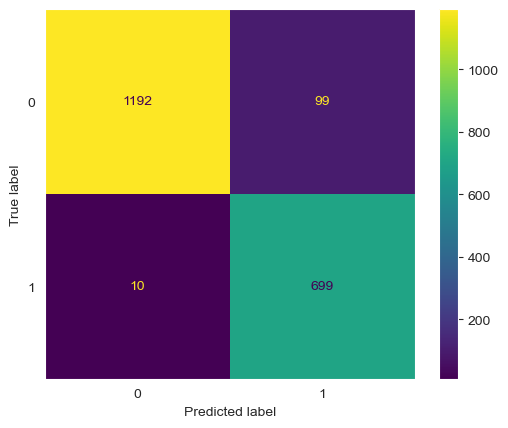

In [21]:
sns.set_style('dark')

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=nb_classifier.classes_).plot();

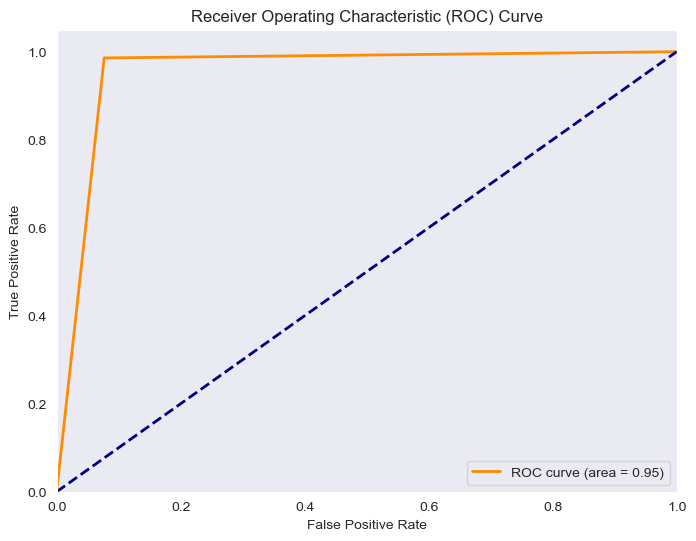

In [22]:
from sklearn.metrics import auc
# Compute the ROC curve and area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve using Seaborn's lineplot
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Conclusion:
To wrap up, we've gone through the steps of data preprocessing, visualization, model training, and evaluation. This process provides a baseline model for predicting patient readmission, and there are many opportunities for further refinement and exploration